In [7]:
import pandapower as pp
import pandas as pd
import numpy as np
import enlopy as el
import matplotlib.pyplot as plt

%matplotlib notebook

# Active network managment. Setup inspired by [this article](https://link.springer.com/content/pdf/10.1007%2Fs11081-016-9339-9.pdf).

## Create forecasted demand for the next T hours (24 perhaps)

<IPython.core.display.Javascript object>


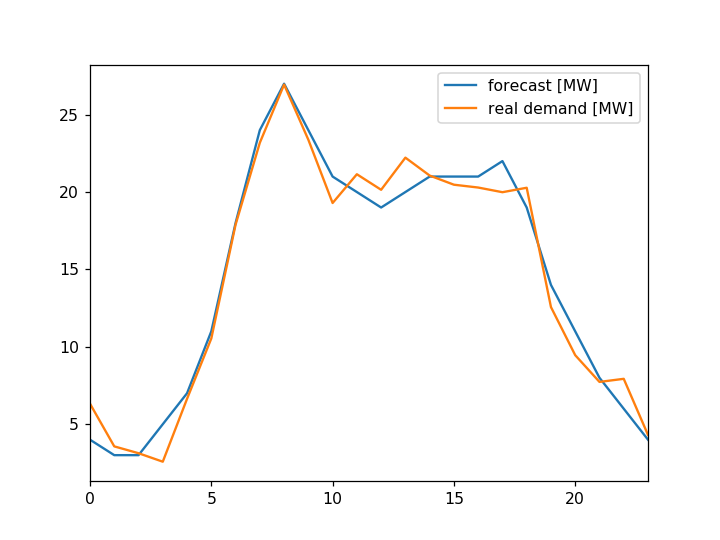

In [37]:
# demand in MW
forecast = np.array([4,3,3,5,7,11,18,24,27,24,21,20,19,20,21,21,21,22,19,14,11,8,6,4])
sigma = 1.3
np.random.seed(3)
random_var = forecast + sigma*np.random.randn(24)
df = pd.DataFrame(data=forecast,columns=['forecast [MW]'])
df['real demand [MW]'] = random_var
df.plot()

## Checking out elopy

In [315]:
load = el.generate.gen_daily_stoch_el()
plt.plot(load,axes=ax)

## The forecast could be the first state vector $s_{1}$
It is also necessary to keep track of what the flexible loads actually recieve. The demand can be shifted in time, but not altered in total. This can be done by keeping track of the devation from desired load. For each time step, there will be a forecasted, actual and modified load. Forecasted load is given given by some model, the actual load is some random deviation from the forecast, and the modified load is the resulting load after an action is taken, for instance reducing the load due to  risks of violating voltage bounds. 

<IPython.core.display.Javascript object>


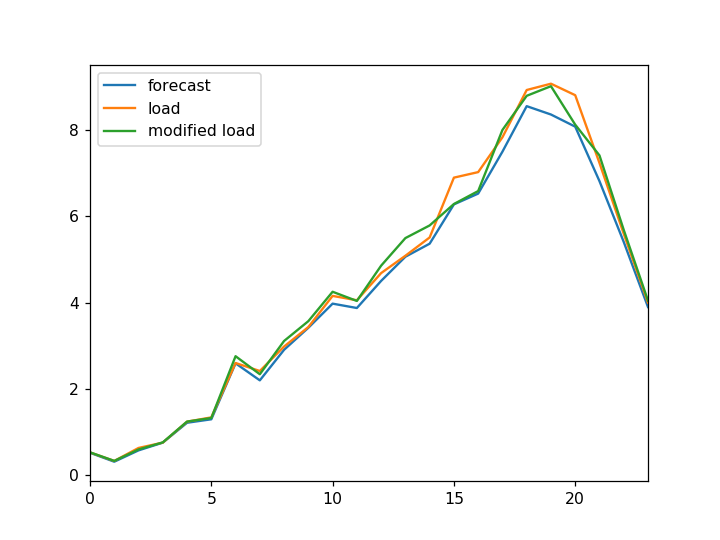

In [605]:

actual_loads = []
modified_loads = []
daily_consumption = 100 #MWh
forecasts = daily_consumption*el.generate.gen_daily_stoch_el()

for forecast in forecasts:
    std = 0.1
    #The actual load is revealed after an action is taken
    actual_load = forecast + forecast*std*np.random.rand()
    actual_loads.append(actual_load)
    #The action gives the modified load, here a random modification is simply added
    modified_load = forecast + forecast*std*np.random.rand() 
    modified_loads.append(modified_load)
    
df = pd.DataFrame()
df['forecast'] = forecasts
df['load'] = actual_loads
df['modified load'] = modified_loads
df.plot()

## Reward function
The original paper also uses the notion of a reward function that give an imediate reward after an action. They define the reward as the negative of the cost the action the agent performs. The cost consists of three parts:
- The cost of reducing the power at a generator:
Some of the generators in the system can reduce its production. The costs is curtainment of production at distributed generation units. 

- The cost of activating flexible loads

- The cost of the next state $s_{t+1}$. This part aims to penalise undesired states in the system.

## Network topology
The network should have a large amount distributed generation units, that represents could represent solar and wind power units. This 14 bus [CIGRE network](https://pandapower.readthedocs.io/en/v1.6.1/networks/cigre.html#medium-voltage-distribution-network-with-pv-and-wind-der) contains  9 distributed energy resources compared to medium voltage distribution network:

- 8 photovoltaic generators
- 1 wind turbine

This network topology also has more distributed generation units, and can be loaded by setting `with_der` equal to 'all'. In general. CIGRE-Networks were developed by the CIGRE Task Force C6.04.02 to “facilitate the analysis and validation of new methods and techniques” that aim to “enable the economic, robust and environmentally responsible integration of DER” (Distributed Energy Resources). CIGRE-Networks are a set of comprehensive reference systems to allow the “analysis of DER integration at high voltage, medium voltage and low voltage and at the desired degree of detail”.

In [21]:
import pandapower.networks as pn
import pandapower as pp
import pandas as pd
from pandapower.plotting.plotly import simple_plotly,pf_res_plotly, vlevel_plotly
import os 
import dotenv
DATA_PATH = os.getenv('DATA_PATH')
dotenv.load_dotenv()
%matplotlib notebook
net = pn.create_cigre_network_mv(with_der="pv_wind")
pp.runpp(net)

In [22]:
net.res_bus.head()

,vm_pu,va_degree,p_kw,q_kvar
0,1.030000,0.000000,-43196.501639,-15696.168750
1,0.994133,-6.045087,19839.000000,4637.136047
2,0.977804,-6.573027,0.000000,0.000000
3,0.951848,-7.414877,481.700000,208.882313
4,0.950094,-7.508922,411.650000,108.181687


The PV panels have quite a small nominel ratings for power. To push the grid into difficult situations, I will scale this up by a order of 50. This means that the nominal values ranges from 1 to 2 MW

In [23]:
net.sgen

,name,bus,p_kw,q_kvar,sn_kva,scaling,in_service,type
0,PV 3,3,-20.0,0.0,20.0,1.0,True,PV
1,PV 4,4,-20.0,0.0,20.0,1.0,True,PV
2,PV 5,5,-30.0,0.0,30.0,1.0,True,PV
3,PV 6,6,-30.0,0.0,30.0,1.0,True,PV
4,PV 8,8,-30.0,0.0,30.0,1.0,True,PV
5,PV 9,9,-30.0,0.0,30.0,1.0,True,PV
6,PV 10,10,-40.0,0.0,40.0,1.0,True,PV
7,PV 11,11,-10.0,0.0,10.0,1.0,True,PV
8,WKA 7,7,-1500.0,0.0,1500.0,1.0,True,WP


In [24]:
net.sgen['sn_kva'] *= 50
net.sgen.loc[8,'sn_kva'] /= 50 #undo scaling for wind park
net.sgen


,name,bus,p_kw,q_kvar,sn_kva,scaling,in_service,type
0,PV 3,3,-20.0,0.0,1000.0,1.0,True,PV
1,PV 4,4,-20.0,0.0,1000.0,1.0,True,PV
2,PV 5,5,-30.0,0.0,1500.0,1.0,True,PV
3,PV 6,6,-30.0,0.0,1500.0,1.0,True,PV
4,PV 8,8,-30.0,0.0,1500.0,1.0,True,PV
5,PV 9,9,-30.0,0.0,1500.0,1.0,True,PV
6,PV 10,10,-40.0,0.0,2000.0,1.0,True,PV
7,PV 11,11,-10.0,0.0,500.0,1.0,True,PV
8,WKA 7,7,-1500.0,0.0,1500.0,1.0,True,WP


Next question. There must be a forecasted energy production from the solar farms. I have hourly solar irradiance data from Konongo in Ghana 

In [25]:
solar = pd.read_csv('2017.csv')
solar = solar.iloc[::12,:]
solar = solar.iloc[:,[2]]

In [26]:
solar.head()

,Solar Radiation [w/m^2]
0,0.00815
12,0.00503
24,0.01597
36,-0.00526
48,0.00904


In [27]:
solar.tail()

,Solar Radiation [w/m^2]
105060,0.00149
105072,0.00403
105084,0.00601
105096,0.01556
105108,0.01270


<IPython.core.display.Javascript object>


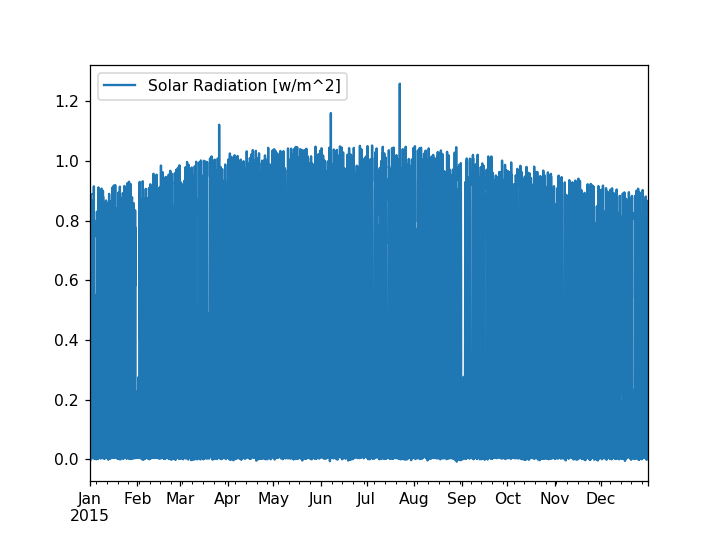

In [28]:
dates = pd.date_range('01-01-2015','31-12-2015 23:00',freq='H')
solar.index = dates
solar.plot()

In [33]:
def save_solar_data():
    solar_path = os.path.join(DATA_PATH,'solar_irradiance_2015.hdf')
    solar.to_hdf(solar_path,key='sun',format='table')



In [63]:
a = []
for _ in range (13):
    a.append(np.random.random([24]))
b = np.random.random(24)
c = np.random.random(40)

In [65]:
%%timeit
state = []
for k in a:
    state += list(k)
state += list(b)
state += list(c)


79.4 µs ± 5.18 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [69]:
a2 = np.array(a)
a2.ravel()

array([0.91924598, 0.27557469, 0.61340228, 0.89757513, 0.36739317,
       0.41528881, 0.20529421, 0.04688781, 0.54538432, 0.74970711,
       0.94427803, 0.2900044 , 0.28856372, 0.31433457, 0.07830974,
       0.18537684, 0.12484088, 0.55481332, 0.24787403, 0.94965749,
       0.76204739, 0.15670408, 0.47492635, 0.91898914, 0.42571001,
       0.00448036, 0.68035449, 0.53255776, 0.67278056, 0.60507645,
       0.05093266, 0.33831518, 0.24476448, 0.49864699, 0.97131325,
       0.95719683, 0.06288027, 0.37132584, 0.66124399, 0.83676515,
       0.6513559 , 0.50103965, 0.68074845, 0.4421088 , 0.10301008,
       0.91490468, 0.7652697 , 0.85916493, 0.70333852, 0.9442997 ,
       0.67701658, 0.55157966, 0.53065925, 0.66545722, 0.86332832,
       0.93940765, 0.50997497, 0.10316334, 0.40514921, 0.12840586,
       0.05692263, 0.12697653, 0.77786855, 0.82697956, 0.04098469,
       0.22983158, 0.34007448, 0.91345003, 0.91016218, 0.21759455,
       0.53241127, 0.55474537, 0.89956972, 0.67353843, 0.51317